# Wrapped Gaussian

In [35]:
import numpy as np
from scipy import optimize
from numpy import pi
import matplotlib.pyplot as plt

# Fitting function (bivariate)
def vM_bivar(coord_data_tuple, I, phi0, psi0, stdev_phi, stdev_psi):
    phi, psi = coord_data_tuple
    phi = phi.ravel()
    psi = psi.ravel()
    f = I * np.exp(stdev_phi * np.cos(phi-phi0) + stdev_psi * np.cos(psi-psi0))
    return f

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

#########################################################################################

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)         
                        + c*((y-yo)**2)))                                   
    return g.ravel()

def vM_bivar2(coord_data_tuple, I, phi0, psi0, stdev_phi, stdev_psi, theta):
    phi, psi = coord_data_tuple
    phi = phi.ravel()
    psi = psi.ravel()
    a = (np.cos(theta)**2)/(2*stdev_phi**2) + (np.sin(theta)**2)/(2*stdev_psi**2)   
    b = -(np.sin(2*theta))/(4*stdev_phi**2) + (np.sin(2*theta))/(4*stdev_psi**2)    
    c = (np.sin(theta)**2)/(2*stdev_phi**2) + (np.cos(theta)**2)/(2*stdev_psi**2)  
    f = I * np.exp(- (a*np.cos(phi-phi0)**2) + 2*b*np.cos(phi-phi0)*np.cos(psi-psi0) + c*np.cos(psi-psi0)**2)
    return f

In [74]:
# Data to fit (2D)
wdir = '.'
map_id = 1
data = np.load(f"{wdir}/Maps/{str(map_id)}_18x10.npy")
data = data/data.max()

# Coordinate space to calculate the function for:
Phi, Psi = np.meshgrid(np.linspace(-1*pi, pi, data.shape[1]),
                       np.linspace(-1*pi, 0, data.shape[0]))

#initial_guess = moments(data)
popt, pcov = optimize.curve_fit(vM_bivar2, (Phi, Psi), data.ravel())#, initial_guess)

# Calculating fit data with the obtained parameters
fit_data = vM_bivar2((Phi, Psi), *popt)
fit_data = np.reshape(fit_data, data.shape)

## Visualisation

plt.imshow(data, cmap=plt.cm.YlGnBu, extent=(-1*pi, 0, -1*pi, pi))
plt.contour(fit_data, extent=(-1*pi, 0, -1*pi, pi), origin='upper')
plt.figure()
plt.imshow(fit_data, cmap=plt.cm.YlGnBu, extent=(-1*pi, 0, -1*pi, pi))

plt.figure()
plt.imshow(pcov)

FileNotFoundError: [Errno 2] No such file or directory: './Maps/1_18x10.npy'

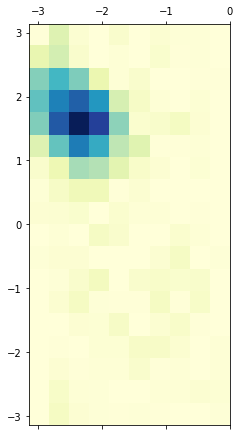

<Figure size 432x288 with 0 Axes>

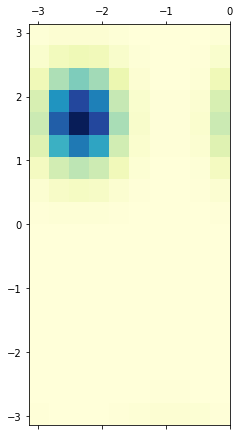

In [45]:
## Visualisation

plt.matshow(data, cmap=plt.cm.YlGnBu, extent=(-1*pi, 0, -1*pi, pi))
plt.figure()
plt.matshow(fit_data, cmap=plt.cm.YlGnBu, extent=(-1*pi, 0, -1*pi, pi))

amplitude, xo, yo, sigma_x, sigma_y, theta, offset
[ -0.508 118.859 -55.403   2.153 216.017  -1.137   0.413]


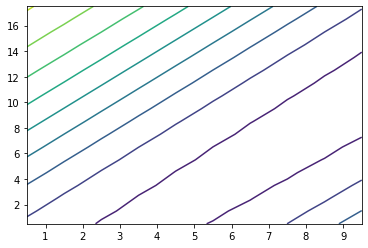

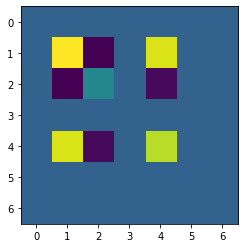

In [71]:
popt, pcov = optimize.curve_fit(twoD_Gaussian, (Phi, Psi), data.ravel())

fit_data = twoD_Gaussian((Phi, Psi), *popt)
fit_data = np.reshape(fit_data, data.shape)

#plt.imshow(data, cmap='YlGnBu_r', interpolation='bilinear', extent=(-1*pi, 0, -1*pi, pi))
plt.contour(fit_data, 8, origin='upper')
plt.figure()
plt.imshow(pcov)

print('amplitude, xo, yo, sigma_x, sigma_y, theta, offset')
print(np.round(popt, 3))